In [ ]:
###############################################################################
# The Institute for the Design of Advanced Energy Systems Integrated Platform
# Framework (IDAES IP) was produced under the DOE Institute for the
# Design of Advanced Energy Systems (IDAES).
#
# Copyright (c) 2018-2023 by the software owners: The Regents of the
# University of California, through Lawrence Berkeley National Laboratory,
# National Technology & Engineering Solutions of Sandia, LLC, Carnegie Mellon
# University, West Virginia University Research Corporation, et al.
# All rights reserved.  Please see the files COPYRIGHT.md and LICENSE.md
# for full copyright and license information.
###############################################################################

# Supercritical CO2 Property Surrogate with PySMO Surrogate Object - Training Surrogate (Part 1)
Maintainer: Javal Vyas

Author: Javal Vyas

Updated: 2024-01-24
## 1. Introduction
This notebook illustrates the use of the PySMO Polynomial surrogate trainer to produce an ML surrogate based on supercritical CO2 data from simulation using REFPROP package. PySMO also has other training methods like Radial Basis Function and Kriging surrogate models, but we focus on Polynomial surrogate model. 

There are several reasons to build surrogate models for complex processes, even when higher fidelity models already exist (e.g., reduce model size, improve convergence reliability, replace models with externally compiled code and make them fully-equation oriented).

In this example, we intend to make a surrogate for the physical properties of S-CO2 to be embedded in the property package. This property package will be used to get the physical properties of S-CO2 in the flowsheet simulation. To learn more about property package, see the [IDAES-PSE](https://github.com/IDAES/idaes-pse) Github Page or IDAES [Read-the-docs](https://idaes-pse.readthedocs.io/en/latest/). 


### 1.1 Need for ML Surrogates

The properties predicted by the surrogate are enthalpy and entropy of the S-CO2 based on the 
pressure and temperature of the system. The analytical equation of getting the enthalpy and entropy from pressure and temperature are in the differential form and would make the problem a DAE system. To counter this problem and keep the problem algebraic, we will use the ML surrogates and relate enthalpy and entropy with the pressure and temperature as an algebraic equation.

### 1.2 Supercritical CO2 cycle process

The following flowsheet will be used to optimize the design for the cooling of the fusion reactor using supercritical CO2 cycle. We shall focus on training the surrogate for this notebook and move to constructing the flowsheet and the properties package in the subsequent notebooks. The take away from this flowsheet is that, 3 variables can be measured in any given unit which are flow, pressure and temperature and other properties can be calculated using them. Thus, surrogate should have pressure and temperature as the inputs.

In this example, we will train the model using polynomial regression for our data and then demonstrate that we can solve an optimization problem with that surrogate model. 

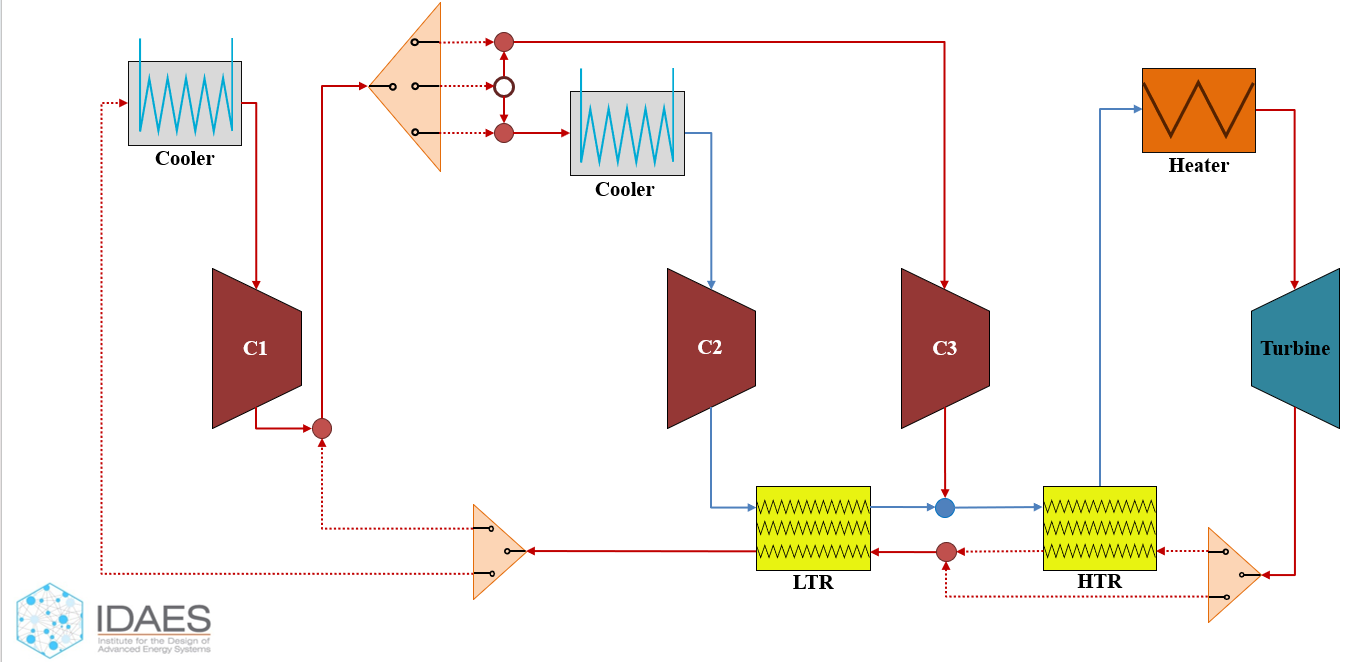

In [1]:
from IPython.display import Image
from pathlib import Path


def datafile_path(name):
    return Path("..") / name


Image(datafile_path("CO2_flowsheet.png"))

## 2. Training and Validating Surrogate

First, let's import the required Python and IDAES modules:

In [2]:
# Import statements
import os
import numpy as np
import pandas as pd

# Import IDAES libraries
from idaes.core.surrogate.sampling.data_utils import split_training_validation
from idaes.core.surrogate.pysmo_surrogate import PysmoPolyTrainer, PysmoSurrogate
from idaes.core.surrogate.plotting.sm_plotter import (
    surrogate_scatter2D,
    surrogate_parity,
    surrogate_residual,
)

### 2.1 Importing Training and Validation Datasets

In this section, we read the dataset from the CSV file located in this directory. 500 data points were simulated for S-CO2 physical properties using REFPROP package. This example is trained on the entire dataset because neural  network can overfit on smaller dataset. The data is separated using an 80/20 split into training and validation data using the IDAES split_training_validation() method.

We rename the column headers because they contained ".", which may cause errors while reading the column names in subsequent code, thus as a good practice we change them to the variable names to be used in the property package. Further, the input variables are **pressure**, **temperature** , while the output variables are **enth_mol**, **entr_mol**, hence we create two new dataframes for the input and output variables. 

In [3]:
# Import training data
np.set_printoptions(precision=6, suppress=True)

csv_data = pd.read_csv(datafile_path("500_Points_DataSet.csv"))
csv_data.columns.values[0:6] =["pressure", "temperature","enth_mol","entr_mol","CO2_enthalpy","CO2_entropy"]
data = csv_data.sample(n=500)

input_data = data.iloc[:, :2]
output_data = data.iloc[:, 2:4]

# # Define labels, and split training and validation data
input_labels = list(input_data.columns)
output_labels =  list(output_data.columns) 

n_data = data[input_labels[0]].size
data_training, data_validation = split_training_validation(
    data, 0.8, seed=n_data
)

### 2.2 Training Surrogates with PySMO

IDAES builds a model class for each type of PySMO surrogate model. In this case, we will call and build the Polynomial Regression class. Regression settings can be directly passed as class arguments, as shown below. In this example, allowed basis terms span a 5th order polynomial, a variable product as well as a extra features are defined, and data is internally cross-validated using 10 iterations of 80/20 splits to ensure a robust surrogate fit. Note that PySMO uses cross-validation of training data to adjust model coefficients and ensure a more accurate fit, while we separate the validation dataset pre-training in order to visualize the surrogate fits.

Finally, after training the model we save the results and model expressions to a folder which contains a serialized JSON file. Serializing the model in this fashion enables importing a previously trained set of surrogate models into external flowsheets. This feature will be used later.

In [4]:
# Create PySMO trainer object
trainer = PysmoPolyTrainer(
    input_labels=input_labels,
    output_labels=output_labels,
    training_dataframe=data_training,
)

var = output_labels
trainer.config.extra_features=['pressure*temperature*temperature','pressure*pressure*temperature*temperature','pressure*pressure*temperature','pressure/temperature','temperature/pressure']
# Set PySMO options
trainer.config.maximum_polynomial_order = 5
trainer.config.multinomials = True
trainer.config.training_split = 0.8
trainer.config.number_of_crossvalidations = 10

# Train surrogate (calls PySMO through IDAES Python wrapper)
poly_train = trainer.train_surrogate()

# create callable surrogate object
xmin, xmax = [7,306], [40,1000]
input_bounds = {input_labels[i]: (xmin[i], xmax[i]) for i in range(len(input_labels))}
poly_surr = PysmoSurrogate(poly_train, input_labels, output_labels, input_bounds)
# save model to JSON
model = poly_surr.save_to_file("pysmo_poly_surrogate.json", overwrite=True)


===========================Polynomial Regression===============================================


No iterations will be run.
Default parameter estimation method is used.
Parameter estimation method:  pyomo 

No iterations will be run.
model.name="unknown";
    - termination condition: maxIterations
    - message from solver: Ipopt 3.13.2\x3a Maximum Number of Iterations
      Exceeded.
model.name="unknown";
    - termination condition: maxIterations
    - message from solver: Ipopt 3.13.2\x3a Maximum Number of Iterations
      Exceeded.
model.name="unknown";
    - termination condition: maxIterations
    - message from solver: Ipopt 3.13.2\x3a Maximum Number of Iterations
      Exceeded.
model.name="unknown";
    - termination condition: maxIterations
    - message from solver: Ipopt 3.13.2\x3a Maximum Number of Iterations
      Exceeded.
model.name="unknown";
    - termination condition: maxIterations
    - message from solver: Ipopt 3.13.2\x3a Maximum Number of Iterations
      Exce

### 2.3 Visualizing surrogates
Now that the surrogate models have been trained, the models can be visualized through scatter, parity and residual plots to confirm their validity in the chosen domain. The training data will be visualized first to confirm the surrogates are fit the data, and then the validation data will be visualized to confirm the surrogates accurately predict new output values.

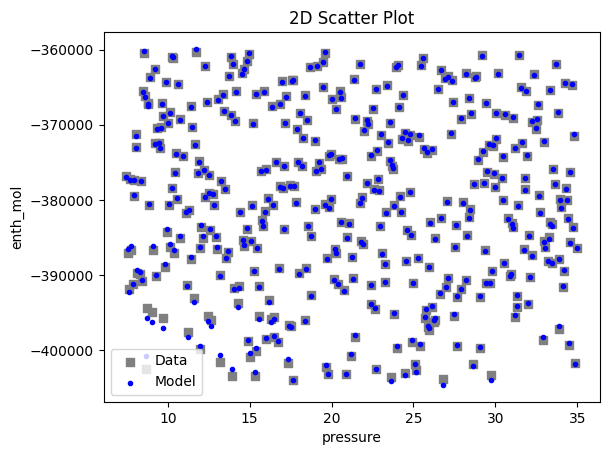

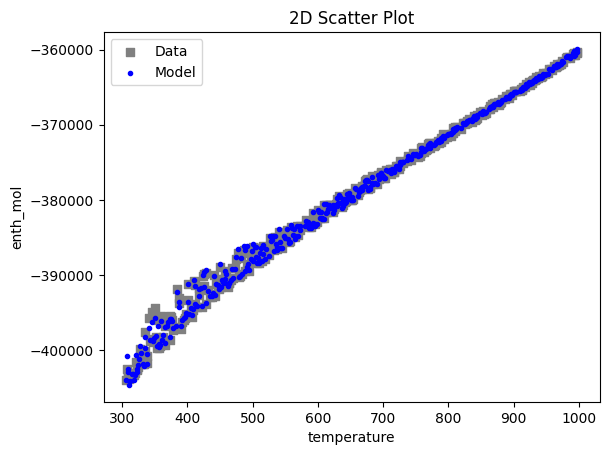

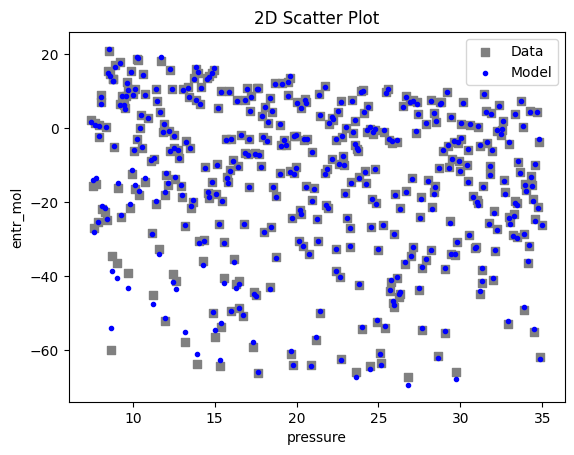

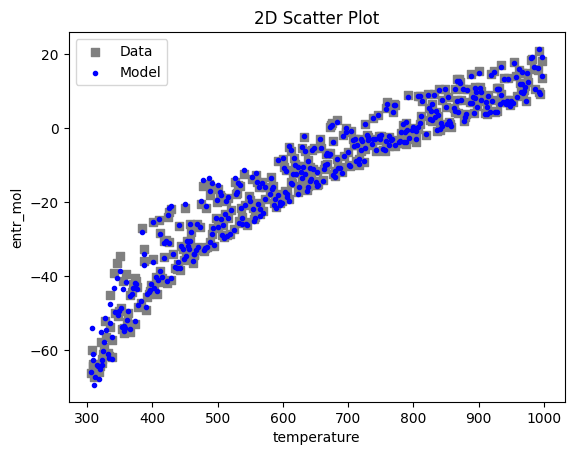

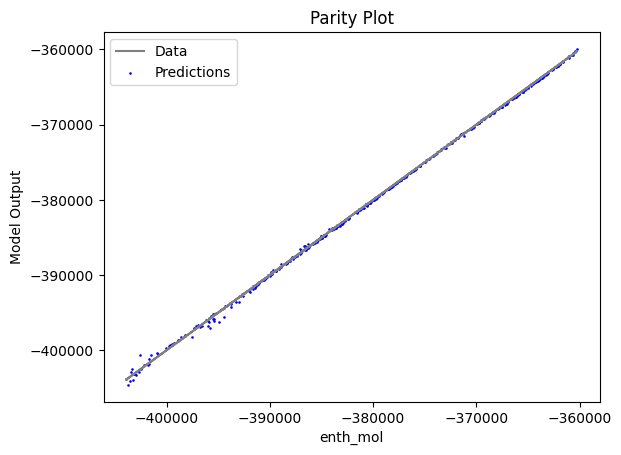

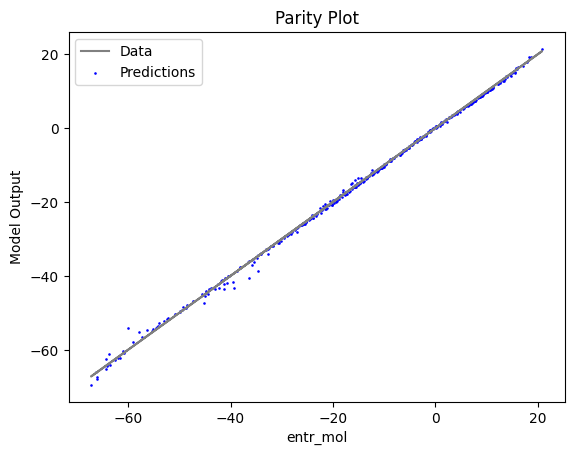

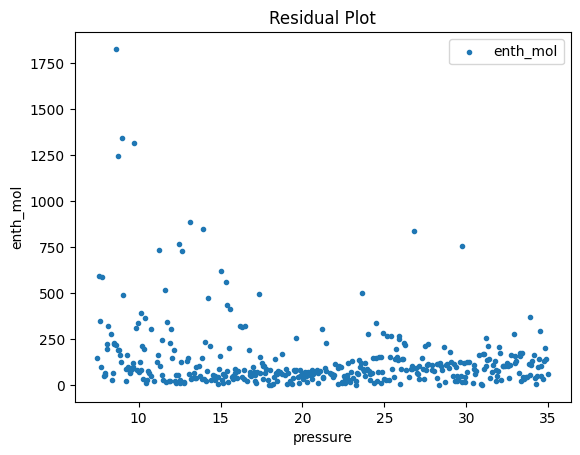

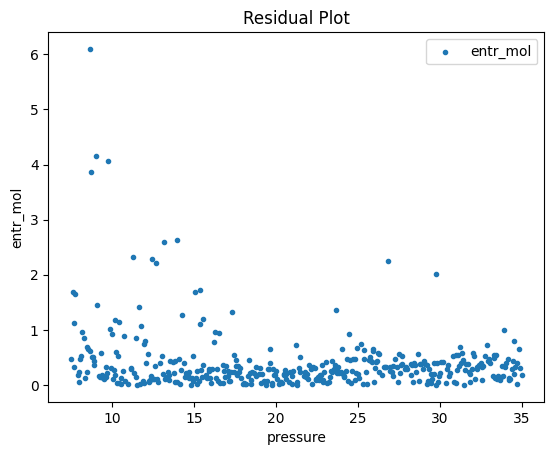

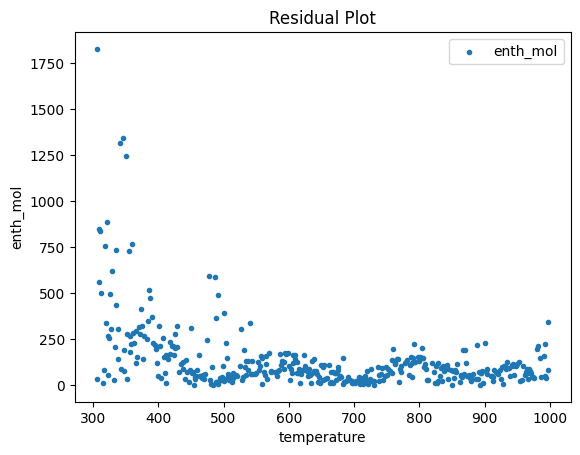

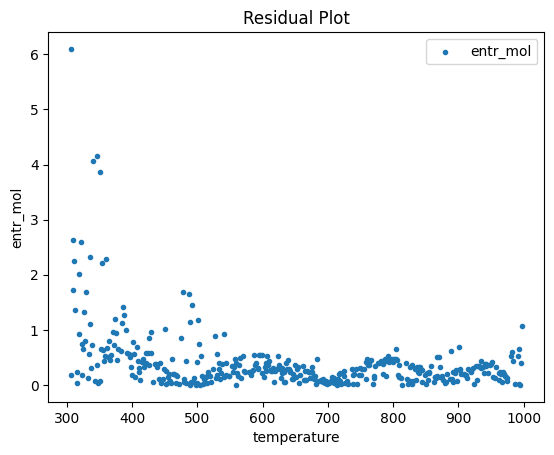

In [5]:
# visualize with IDAES surrogate plotting tools
surrogate_scatter2D(poly_surr, data_training, filename="pysmo_poly_train_scatter2D.pdf")
surrogate_parity(poly_surr, data_training, filename="pysmo_poly_train_parity.pdf")
surrogate_residual(poly_surr, data_training, filename="pysmo_poly_train_residual.pdf")

### 2.4 Model Validation

We check the fit on the validation set to see if the surrogate is fitting well. This step can be used to check for overfitting on the training set.

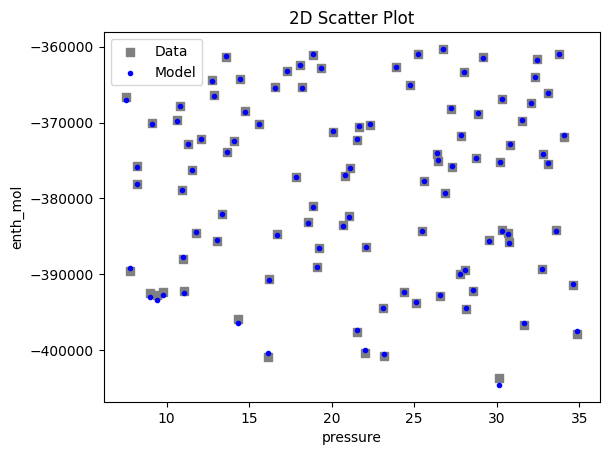

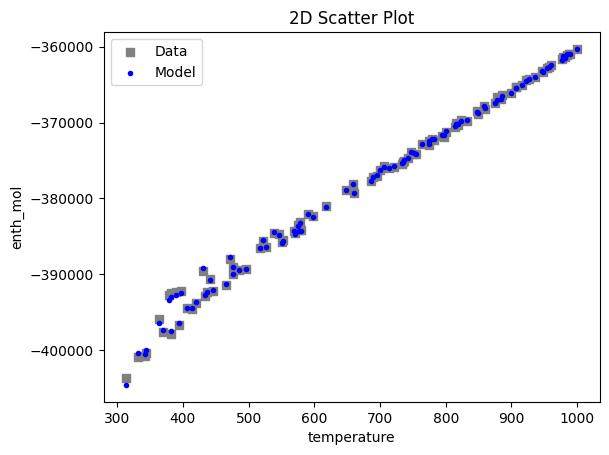

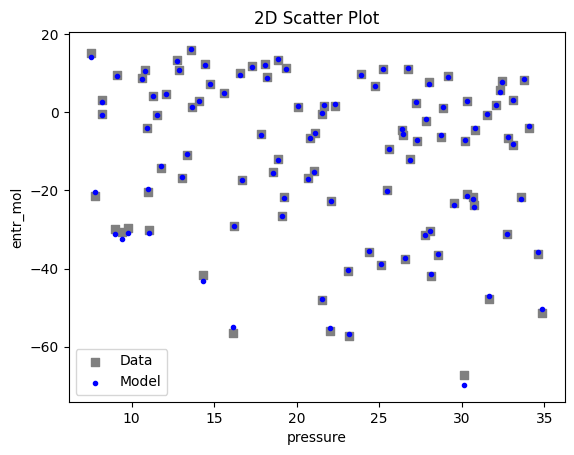

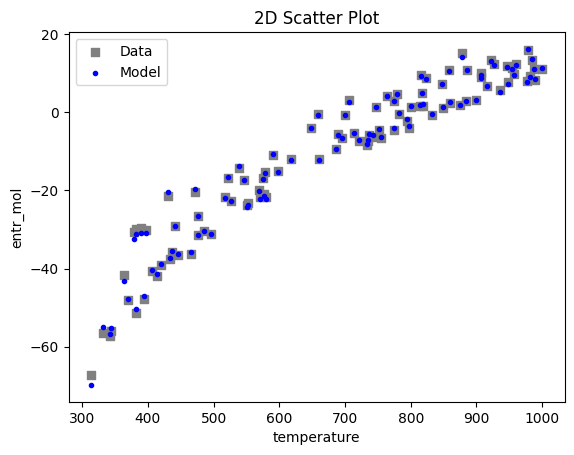

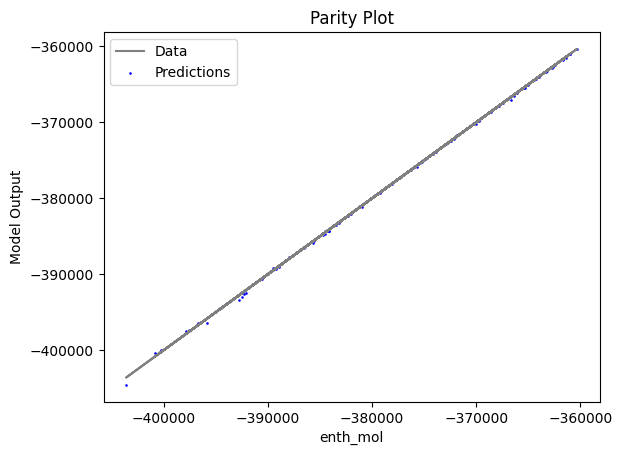

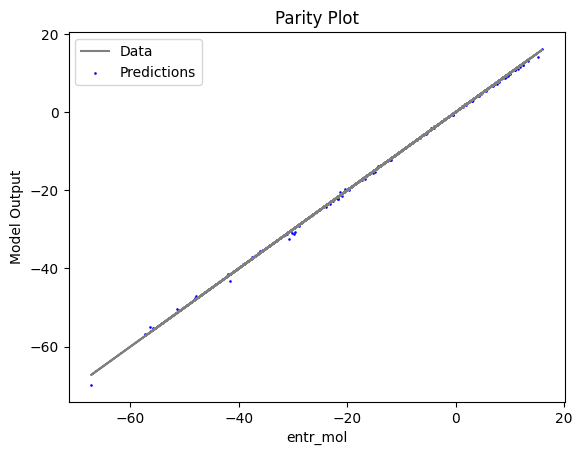

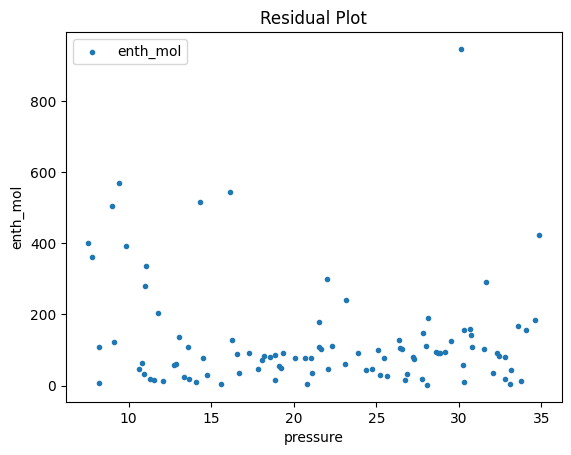

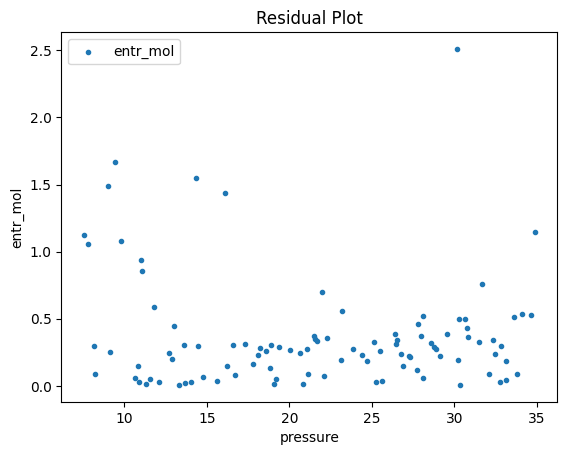

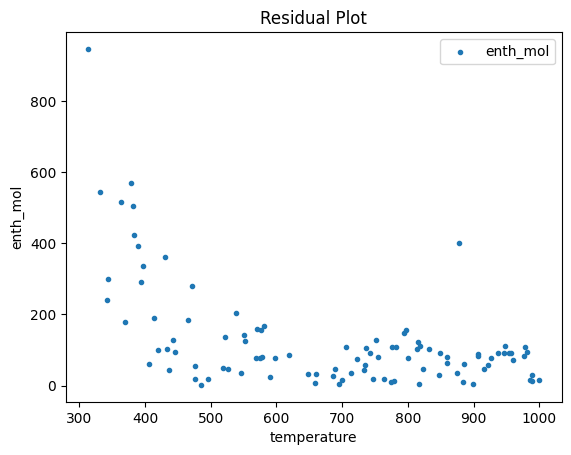

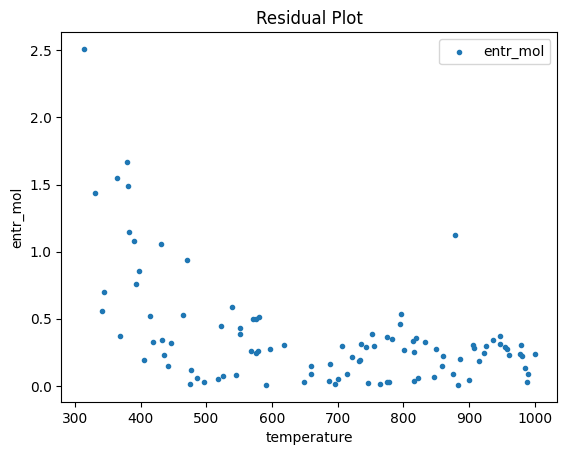

In [6]:
# visualize with IDAES surrogate plotting tools
surrogate_scatter2D(poly_surr, data_validation, filename="pysmo_poly_val_scatter2D.pdf")
surrogate_parity(poly_surr, data_validation, filename="pysmo_poly_val_parity.pdf")
surrogate_residual(poly_surr, data_validation, filename="pysmo_poly_val_residual.pdf")

Now, the surrogate is trained and validated, we shall embed it in the property package, which is demonstrated in the [surrogate_embedding](./surrogate_embedding.ipynb) file.